# CLUSTERING

Кластеризация данных из подсайта Виабу / Аниме. Кластеризация проводится на датасете, который предварительно подготовлен с помощью ноутбука DTF_Weeaboo_data_preparation.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib import gridspec
from pywaffle import Waffle
import seaborn as sns

import math
import itertools

%matplotlib inline
plt.rcParams["figure.figsize"] = [14, 10]

%config Completer.use_jedi = False

sns.set_theme()

print("Imports Done!")

Imports Done!


In [2]:
PATH = "/home/aleksey/PycharmProjects/DTF_database_and_scrapper_config/"

In [3]:
df = pd.read_pickle(PATH + 'Full_analysis/Prepared_weaboo_data_02_05.pkl')
df.head()

,date,id,url,author,comments_count,favorites_count,hits_count,is_repost,likes,subsite,...,videos,links,audio,total_mediacontent,hashtags,hour,month,weekday,is_weekend,period
0,2018-03-12 21:59:15,17110,https://dtf.ru/flood/17110-ne-odin-lish-tip-luny,"{'id': 4876, 'url': 'https://dtf.ru/u/4876-geo...",19,32,1999,True,36,Офтоп,...,3,0,0,45,[#long],21,3,Monday,0,2018-03
1,2020-01-26 20:38:21,97215,https://dtf.ru/u/92907-aleksey-fedorov/97215-t...,"{'id': 92907, 'url': 'https://dtf.ru/u/92907-a...",11,47,665,True,56,Алексей Фёдоров,...,0,0,0,17,[#anime],20,1,Sunday,1,2020-01
2,2020-02-18 19:11:46,104163,https://dtf.ru/u/92907-aleksey-fedorov/104163-...,"{'id': 92907, 'url': 'https://dtf.ru/u/92907-a...",39,23,749,True,49,Алексей Фёдоров,...,0,0,0,32,"[#anime, #evangelion]",19,2,Tuesday,0,2020-02
3,2020-02-29 18:25:10,108055,https://dtf.ru/u/92907-aleksey-fedorov/108055-...,"{'id': 92907, 'url': 'https://dtf.ru/u/92907-a...",7,18,238,True,41,Алексей Фёдоров,...,0,1,0,20,[#anime],18,2,Saturday,1,2020-02
4,2020-03-16 10:36:03,113363,https://dtf.ru/u/4810-oleg-kubaneishvili/11336...,"{'id': 4810, 'url': 'https://dtf.ru/u/4810-ole...",5,8,180,True,15,Олег Кубанеишвили,...,0,0,0,17,[],10,3,Monday,0,2020-03


In [ ]:
df.info()

In [4]:
from sklearn.cluster import DBSCAN
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster

Для кластеризации используется иерархическая кластеризация, поскольку в ходе экспериментов выяснилось, что на собранных данных нормально работает только она.

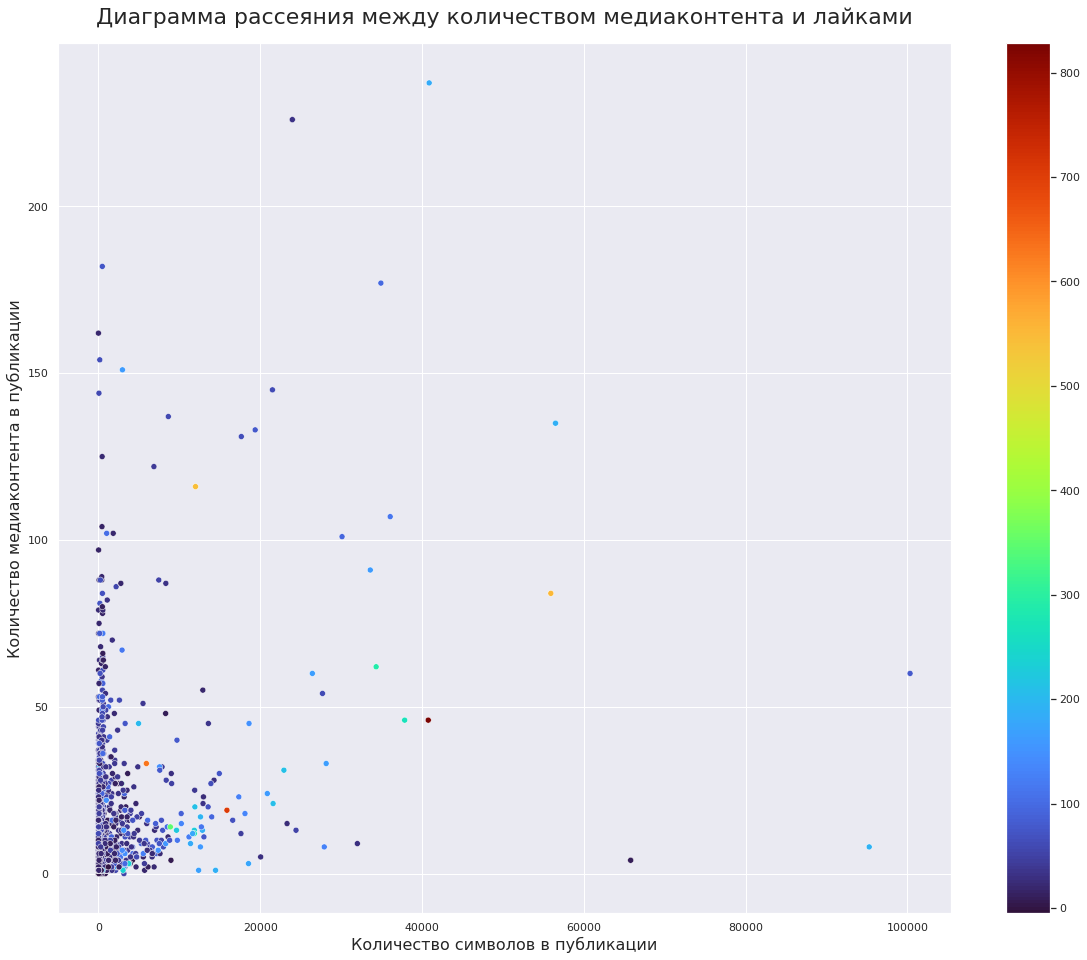

In [5]:
plt.rcParams["figure.figsize"] = [20, 16]

sns.set()
ax = sns.scatterplot(x='symbols', y='total_mediacontent', hue='likes', palette='turbo', data=df)

norm = plt.Normalize(df.likes.min(), df.likes.max())
sm = plt.cm.ScalarMappable(cmap="turbo", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

plt.xlabel('Количество символов в публикации', fontsize=16)
plt.ylabel('Количество медиаконтента в публикации', fontsize=16)
plt.title('Диаграмма рассеяния между количеством медиаконтента и лайками', fontsize=22, pad=20);

# plt.savefig(PATH + "Full_analysis/scatter_symbols_media_likes.jpg", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = [20, 16]
sns.set()
ax = sns.scatterplot(x=np.log(df.symbols + 1), y=np.log(df.total_mediacontent + 1), hue='likes', palette='turbo', data=df)

norm = plt.Normalize(df.likes.min(), df.likes.max())
sm = plt.cm.ScalarMappable(cmap="turbo", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

plt.xlabel('Логарифм от количества символов в публикации', fontsize=16)
plt.ylabel('Логарифм от количества медиаконтента в публикации', fontsize=16)
plt.title('Диаграмма рассеяния между количеством медиаконтента и лайками', fontsize=22, pad=20);

# plt.savefig(PATH + "Full_analysis/scatter_log_symbols_media_likes.jpg", dpi=300, bbox_inches='tight')

plt.show()

# HIERARCHIAL CLUSTERING

In [ ]:
X = np.array([df.symbols, df.total_mediacontent]).T
print(X)

X_scaled = StandardScaler().fit_transform(X)
print(X_scaled)

In [6]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [ ]:
distance_mat = pdist(X_scaled) 
Z = hierarchy.linkage(distance_mat, 'ward') # linkage — реализация агломеративного алгоритма

In [ ]:
plt.figure(figsize=(20, 10))
# выводим размеры кластеров

plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,                   # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,   # to get a distribution impression in truncated branches
)
plt.show()

In [7]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Дендрограмма иерархической кластеризации (усечённая)')
        plt.xlabel('Индекс элемента выборки или (размер кластера)')
        plt.ylabel('Метрика расстояния алгоритма')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [ ]:
plt.figure(figsize=(20, 10))
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)

plt.axhline(25, color='#ff6666', linestyle='-', linewidth=2)

# plt.savefig(PATH + "Full_analysis/clustering_tree.jpg", dpi=300, bbox_inches='tight')

plt.show()

## Наконец-то адекватный результат!

In [ ]:
# Зная расстояние
from scipy.cluster.hierarchy import fcluster
# max_d = 25 # Шикарный результат!
max_d = 21
clusters = fcluster(Z, max_d, criterion='distance')
print(np.unique(clusters))
sns.scatterplot(x=X[:,0], y=X[:,1], hue=clusters, palette='turbo_r', legend='full')

plt.title('Кластеризованные данные', fontsize=22, pad=20)
plt.xlabel('Количество символов в публикациях', fontsize=16)
plt.ylabel('Количество медиаконтента в публикациях', fontsize=16)

# plt.savefig(PATH + "Full_analysis/clustered_data.jpg", dpi=300, bbox_inches='tight')

- Мем
- заметка
- мини_подборка
- статья
- подборка
- супер_подборка
- лонгрид
- супер_лонгрид

https://scikit-learn.org/stable/modules/mixture.html

https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture

https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.inconsistent.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html

https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc

https://scikit-learn.org/stable/modules/preprocessing.html



https://medium.com/@krishnakummar/donut-chart-with-python-matplotlib-d411033c960b

https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html

https://stackoverflow.com/questions/36296101/donut-chart-python

https://seaborn.pydata.org/tutorial/relational.html

In [ ]:
df.head()

In [ ]:
clusters

In [ ]:
df = df.assign(type_of_post=pd.Series(clusters).values)
df.head()

In [ ]:
# print(np.unique(clusters))
# print(df.type_of_post.unique())
# print(clusters == df.type_of_post)

In [ ]:
# Alternative
max_d = 22
clusters = fcluster(Z, max_d, criterion='distance')

# sns.scatterplot(x=X[:,0], y=X[:,1], hue=df.type_of_post, 
#                 style=df.is_repost, palette='turbo_r', s=50, legend='full')

sns.scatterplot(x=df.symbols, y=df.total_mediacontent, hue=df.type_of_post, 
                style=df.is_repost, palette='turbo_r', s=50, legend='full')

In [ ]:
plt.figure(figsize=(20, 10))
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=40,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)
# plt.savefig(PATH + "Full_analysis/deeper_clustering_tree.jpg", dpi=300, bbox_inches='tight')
plt.show()

https://stackoverflow.com/questions/28988627/pandas-correlation-groupby

# Попытка настроить алгоритм на количестве слов, а не на символов

In [8]:
X_alter = np.array([df.words, df.total_mediacontent]).T
print(X_alter)

X_alter_scaled = StandardScaler().fit_transform(X_alter)
print(X_alter_scaled)

[[2012   45]
 [  29   17]
 [  12   32]
 ...
 [  40    8]
 [   6    1]
 [  68    2]]
[[ 4.48401604  3.30726321]
 [-0.06324325  0.98560941]
 [-0.10222631  2.22935252]
 ...
 [-0.03801892  0.23936355]
 [-0.11598504 -0.3410499 ]
 [ 0.02618847 -0.25813369]]


In [9]:
distance_mat_alter = pdist(X_alter_scaled) 
Z_alter = hierarchy.linkage(distance_mat_alter, 'ward') 

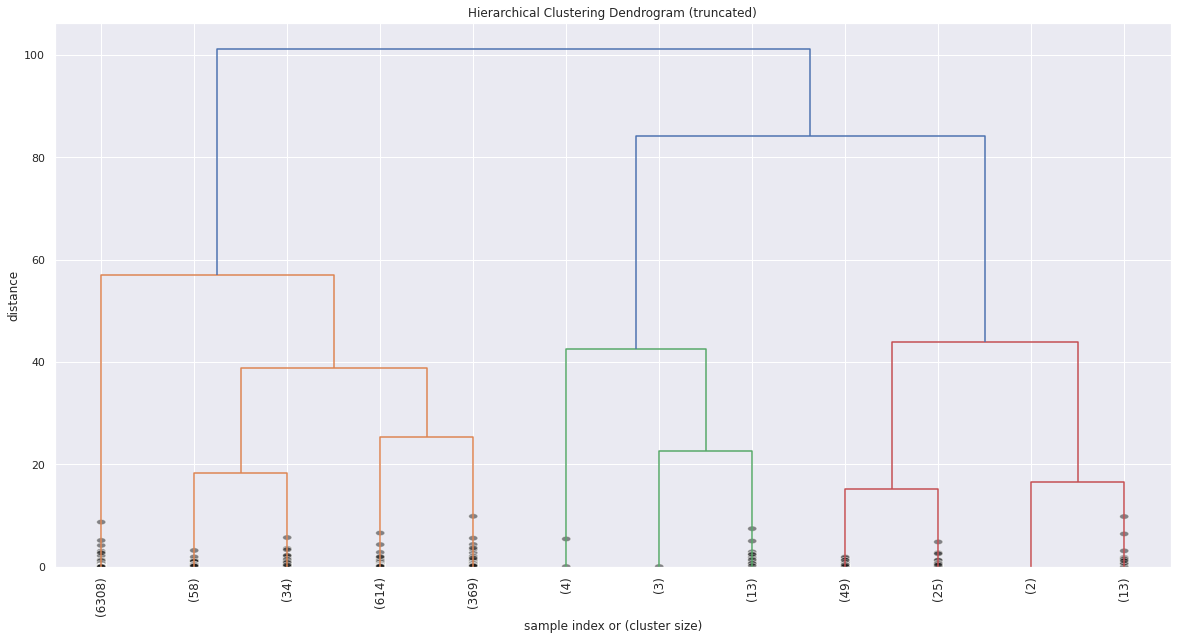

In [10]:
plt.figure(figsize=(20, 10))
# выводим размеры кластеров

plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z_alter,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,                   # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,   # to get a distribution impression in truncated branches
)
plt.show()

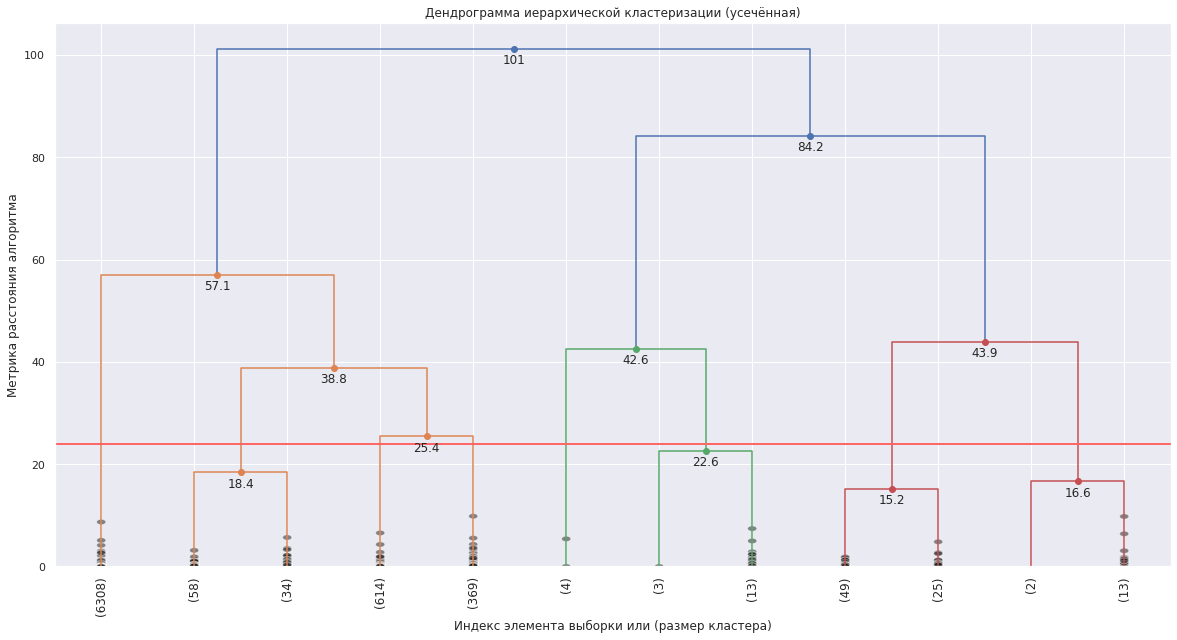

In [11]:
plt.figure(figsize=(20, 10))
fancy_dendrogram(
    Z_alter,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)

plt.axhline(24, color='#ff6666', linestyle='-', linewidth=2)

# plt.savefig(PATH + "Full_analysis/clustering_tree.jpg", dpi=300, bbox_inches='tight')

plt.show()

In [12]:
plt.rcParams["figure.figsize"] = [14, 10]

[1 2 3 4 5 6 7 8]


Text(0, 0.5, 'Количество медиаконтента в публикациях')

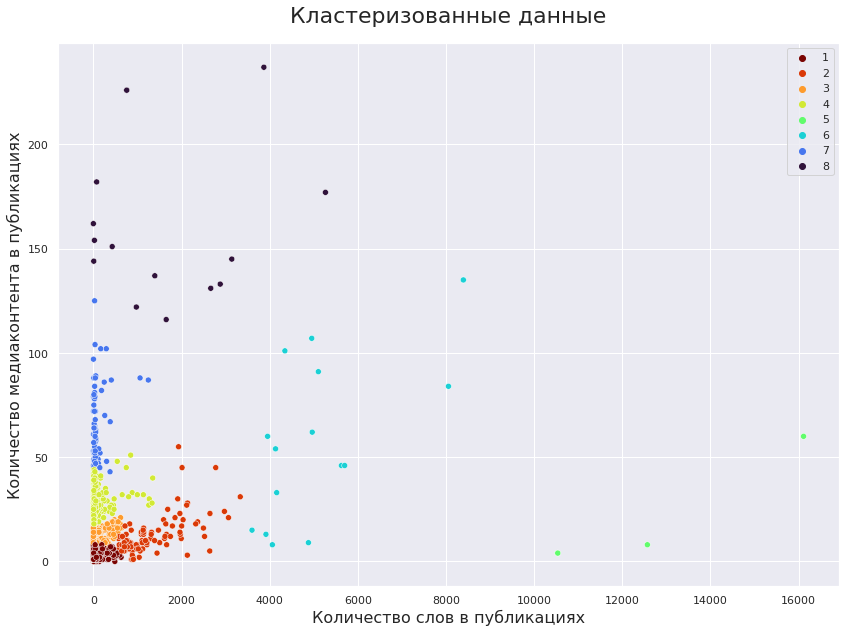

In [13]:
# Зная расстояние
max_d = 24
clusters = fcluster(Z_alter, max_d, criterion='distance')
print(np.unique(clusters))
sns.scatterplot(x=X_alter[:,0], y=X_alter[:,1], hue=clusters, palette='turbo_r', legend='full')

plt.title('Кластеризованные данные', fontsize=22, pad=20)
plt.xlabel('Количество слов в публикациях', fontsize=16)
plt.ylabel('Количество медиаконтента в публикациях', fontsize=16)

# plt.savefig(PATH + "Full_analysis/clustered_data.jpg", dpi=300, bbox_inches='tight')

ДО 25.04.2021

- Заметка
- Статья
- Лонгрид
- Супер_лонгрид_1
- Супер_лонгрид_2
- Ультра_лонгрид
- Подборка
- Супер_подборка
- Супер_медиа_лонгрид

## ПОСЛЕ 01.05.2021

- Заметка
- Статья
- Лонгрид
- Супер_лонгрид
- Ультра_лонгрид
- Подборка
- Супер_подборка
- Супер_медиа_лонгрид

In [14]:
df.head()

,date,id,url,author,comments_count,favorites_count,hits_count,is_repost,likes,subsite,...,videos,links,audio,total_mediacontent,hashtags,hour,month,weekday,is_weekend,period
0,2018-03-12 21:59:15,17110,https://dtf.ru/flood/17110-ne-odin-lish-tip-luny,"{'id': 4876, 'url': 'https://dtf.ru/u/4876-geo...",19,32,1999,True,36,Офтоп,...,3,0,0,45,[#long],21,3,Monday,0,2018-03
1,2020-01-26 20:38:21,97215,https://dtf.ru/u/92907-aleksey-fedorov/97215-t...,"{'id': 92907, 'url': 'https://dtf.ru/u/92907-a...",11,47,665,True,56,Алексей Фёдоров,...,0,0,0,17,[#anime],20,1,Sunday,1,2020-01
2,2020-02-18 19:11:46,104163,https://dtf.ru/u/92907-aleksey-fedorov/104163-...,"{'id': 92907, 'url': 'https://dtf.ru/u/92907-a...",39,23,749,True,49,Алексей Фёдоров,...,0,0,0,32,"[#anime, #evangelion]",19,2,Tuesday,0,2020-02
3,2020-02-29 18:25:10,108055,https://dtf.ru/u/92907-aleksey-fedorov/108055-...,"{'id': 92907, 'url': 'https://dtf.ru/u/92907-a...",7,18,238,True,41,Алексей Фёдоров,...,0,1,0,20,[#anime],18,2,Saturday,1,2020-02
4,2020-03-16 10:36:03,113363,https://dtf.ru/u/4810-oleg-kubaneishvili/11336...,"{'id': 4810, 'url': 'https://dtf.ru/u/4810-ole...",5,8,180,True,15,Олег Кубанеишвили,...,0,0,0,17,[],10,3,Monday,0,2020-03


In [15]:
clusters

array([2, 3, 4, ..., 1, 1, 1], dtype=int32)

In [16]:
df = df.assign(type_of_post=pd.Series(clusters).values)

In [17]:
df.head()

,date,id,url,author,comments_count,favorites_count,hits_count,is_repost,likes,subsite,...,links,audio,total_mediacontent,hashtags,hour,month,weekday,is_weekend,period,type_of_post
0,2018-03-12 21:59:15,17110,https://dtf.ru/flood/17110-ne-odin-lish-tip-luny,"{'id': 4876, 'url': 'https://dtf.ru/u/4876-geo...",19,32,1999,True,36,Офтоп,...,0,0,45,[#long],21,3,Monday,0,2018-03,2
1,2020-01-26 20:38:21,97215,https://dtf.ru/u/92907-aleksey-fedorov/97215-t...,"{'id': 92907, 'url': 'https://dtf.ru/u/92907-a...",11,47,665,True,56,Алексей Фёдоров,...,0,0,17,[#anime],20,1,Sunday,1,2020-01,3
2,2020-02-18 19:11:46,104163,https://dtf.ru/u/92907-aleksey-fedorov/104163-...,"{'id': 92907, 'url': 'https://dtf.ru/u/92907-a...",39,23,749,True,49,Алексей Фёдоров,...,0,0,32,"[#anime, #evangelion]",19,2,Tuesday,0,2020-02,4
3,2020-02-29 18:25:10,108055,https://dtf.ru/u/92907-aleksey-fedorov/108055-...,"{'id': 92907, 'url': 'https://dtf.ru/u/92907-a...",7,18,238,True,41,Алексей Фёдоров,...,1,0,20,[#anime],18,2,Saturday,1,2020-02,4
4,2020-03-16 10:36:03,113363,https://dtf.ru/u/4810-oleg-kubaneishvili/11336...,"{'id': 4810, 'url': 'https://dtf.ru/u/4810-ole...",5,8,180,True,15,Олег Кубанеишвили,...,0,0,17,[],10,3,Monday,0,2020-03,2


<AxesSubplot:xlabel='symbols', ylabel='total_mediacontent'>

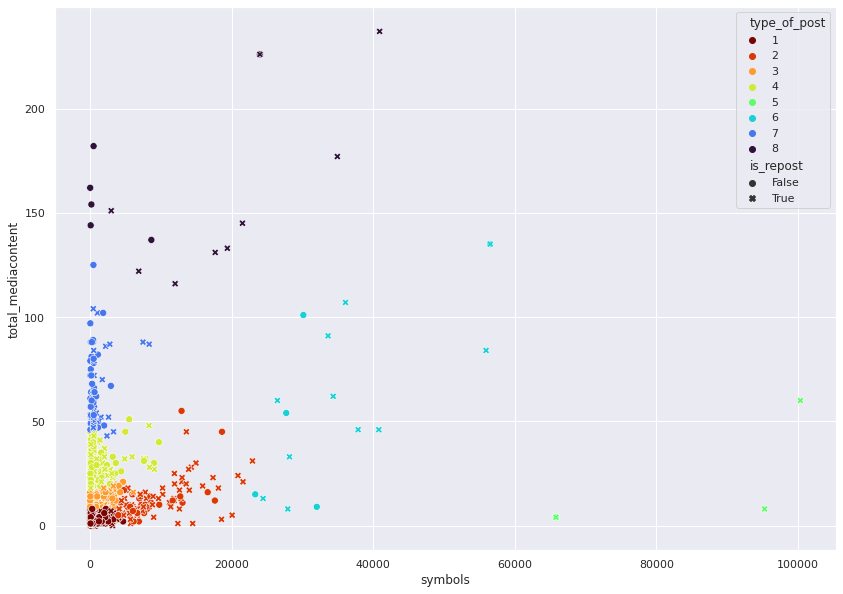

In [18]:
sns.scatterplot(x=df.symbols, y=df.total_mediacontent, hue=df.type_of_post, 
                style=df.is_repost, palette='turbo_r', s=50, legend='full')

<AxesSubplot:xlabel='words', ylabel='total_mediacontent'>

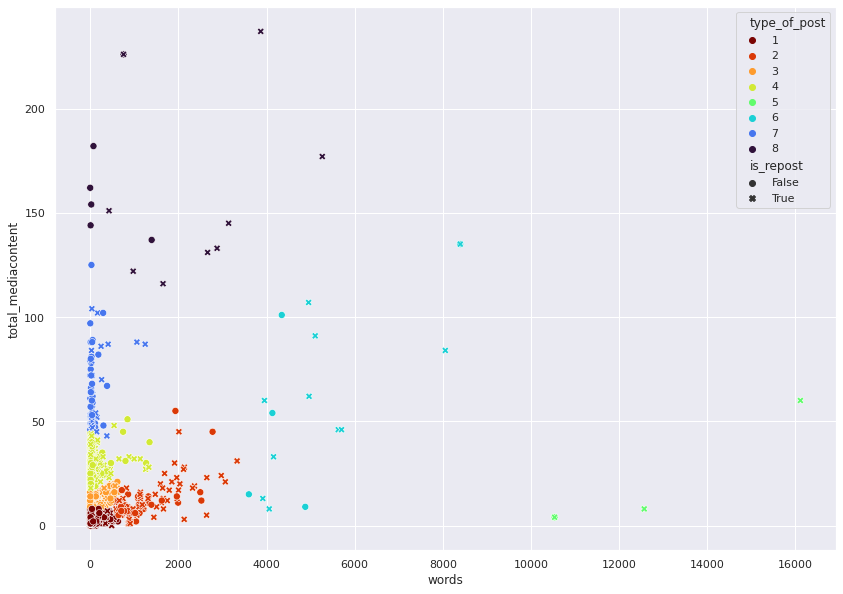

In [19]:
sns.scatterplot(x=df.words, y=df.total_mediacontent, hue=df.type_of_post, 
                style=df.is_repost, palette='turbo_r', s=50, legend='full')

# Попытки выделить мемы

In [20]:
df.head()

,date,id,url,author,comments_count,favorites_count,hits_count,is_repost,likes,subsite,...,links,audio,total_mediacontent,hashtags,hour,month,weekday,is_weekend,period,type_of_post
0,2018-03-12 21:59:15,17110,https://dtf.ru/flood/17110-ne-odin-lish-tip-luny,"{'id': 4876, 'url': 'https://dtf.ru/u/4876-geo...",19,32,1999,True,36,Офтоп,...,0,0,45,[#long],21,3,Monday,0,2018-03,2
1,2020-01-26 20:38:21,97215,https://dtf.ru/u/92907-aleksey-fedorov/97215-t...,"{'id': 92907, 'url': 'https://dtf.ru/u/92907-a...",11,47,665,True,56,Алексей Фёдоров,...,0,0,17,[#anime],20,1,Sunday,1,2020-01,3
2,2020-02-18 19:11:46,104163,https://dtf.ru/u/92907-aleksey-fedorov/104163-...,"{'id': 92907, 'url': 'https://dtf.ru/u/92907-a...",39,23,749,True,49,Алексей Фёдоров,...,0,0,32,"[#anime, #evangelion]",19,2,Tuesday,0,2020-02,4
3,2020-02-29 18:25:10,108055,https://dtf.ru/u/92907-aleksey-fedorov/108055-...,"{'id': 92907, 'url': 'https://dtf.ru/u/92907-a...",7,18,238,True,41,Алексей Фёдоров,...,1,0,20,[#anime],18,2,Saturday,1,2020-02,4
4,2020-03-16 10:36:03,113363,https://dtf.ru/u/4810-oleg-kubaneishvili/11336...,"{'id': 4810, 'url': 'https://dtf.ru/u/4810-ole...",5,8,180,True,15,Олег Кубанеишвили,...,0,0,17,[],10,3,Monday,0,2020-03,2


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7492 entries, 0 to 7491
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 7492 non-null   datetime64[ns]
 1   id                   7492 non-null   int64         
 2   url                  7492 non-null   object        
 3   author               7492 non-null   object        
 4   comments_count       7492 non-null   int64         
 5   favorites_count      7492 non-null   int64         
 6   hits_count           7492 non-null   int64         
 7   is_repost            7492 non-null   bool          
 8   likes                7492 non-null   int64         
 9   subsite              7492 non-null   object        
 10  title                3935 non-null   object        
 11  blocks               7492 non-null   object        
 12  repost               900 non-null    object        
 13  media_content_types  7492 non-nul

In [22]:
tmp = df.groupby(['type_of_post']).agg({'id': 'count'})
tmp

,id
type_of_post,
1,6308
2,92
3,614
4,369
5,4
6,16
7,74
8,15


In [23]:
tmp_2 = df[(df.type_of_post == 1) & (df.total_mediacontent < 2) & (df.symbols < 30)]
tmp_2.shape

(3369, 31)

(0.0, 50.0)

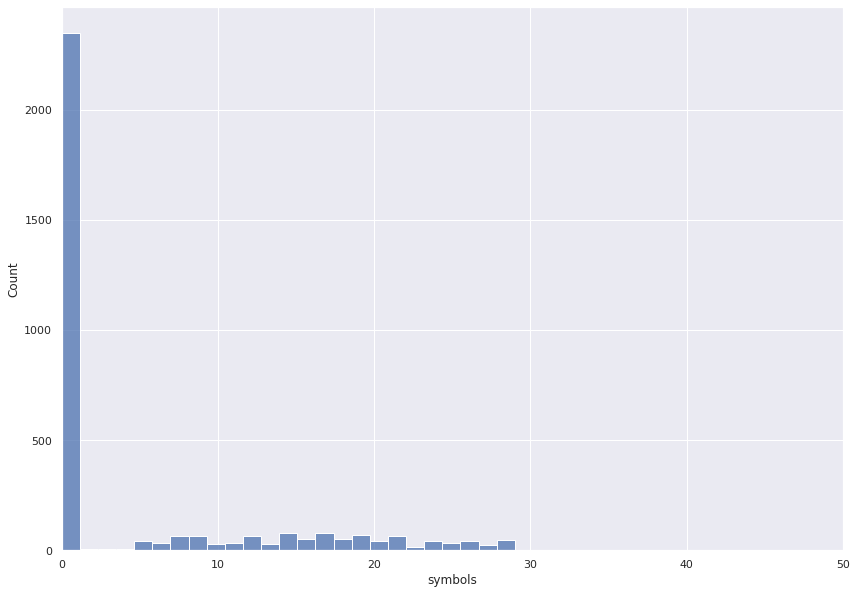

In [24]:
sns.histplot(tmp_2.symbols)
plt.xlim(0, 50)

In [25]:
tmp = df[(df.type_of_post == 1)]

/home/aleksey/PycharmProjects/Machine_Learning_test_area/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='symbols', ylabel='total_mediacontent'>

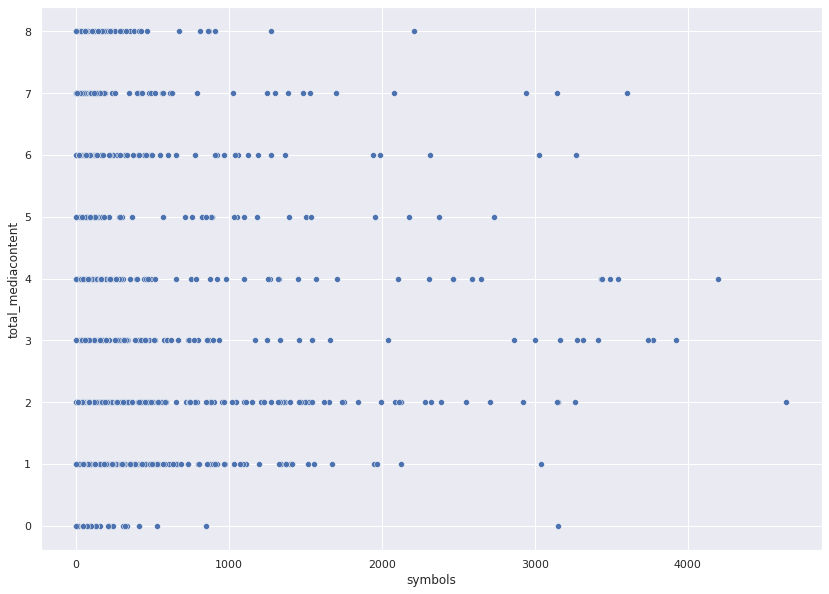

In [26]:
sns.scatterplot(tmp.symbols, tmp.total_mediacontent)

In [27]:
df.type_of_post.unique()

array([2, 3, 4, 1, 8, 7, 5, 6], dtype=int32)

In [28]:
len(df.type_of_post.unique())

8

In [ ]:
# plt.figure(figsize=[16,14])
# sns.scatterplot(x=np.log(df.symbols + 1), y=np.log(df.total_mediacontent +1), hue=df.type_of_post, 
#                 style=df.is_repost, palette='turbo_r', s=50, legend='full')

<AxesSubplot:xlabel='symbols', ylabel='total_mediacontent'>

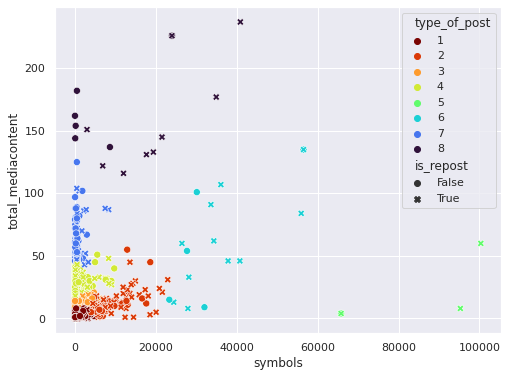

In [29]:
plt.figure(figsize=[8,6])
sns.scatterplot(x=df.symbols, y=df.total_mediacontent, hue=df.type_of_post, 
                style=df.is_repost, palette='turbo_r', s=50, legend='full')

In [ ]:
df_copy = df.copy()

In [ ]:
# OLD
# df_copy.replace({'type_of_post': {1: "Ультра-Медиа-Логрид", 2: "Ультра-Логрид", 3: "Супер-Лонгрид-1", 
#                                   4: "Супер-Лонгрид-2", 5: "Статья", 6: "Заметка", 
#                                   7: "Ультра-Подборка", 8: "Лонгрид", 9: "Подборка"}}, inplace=True)

In [ ]:
df_copy.replace({'type_of_post': {1: "Заметка", 2: "Лонгрид", 3: "Статья", 4: "Подборка", 5: "Ультра-Лонгрид",
                                  6: "Супер-Лонгрид", 7: "Супер-Подборка", 8: "Ультра-Медиа-Лонгрид"
                                 }}, inplace=True)

In [ ]:
plt.figure(figsize=[14, 10])
sns.scatterplot(x=df_copy.symbols, y=df_copy.total_mediacontent, hue=df_copy.type_of_post, 
                palette='turbo', s=50, legend='full')

plt.title('Кластеризованные данные', fontsize=22, pad=20)
plt.xlabel('Количество символов в публикациях', fontsize=16)
plt.ylabel('Количество медиаконтента в публикациях', fontsize=16)
plt.legend(title='Типы публикаций')

# plt.savefig(PATH + "Full_analysis/clustered_labeled_data.jpg", dpi=300, bbox_inches='tight')

In [ ]:
df_copy.loc[df_copy[(df_copy.type_of_post == 'Заметка') & (df_copy.total_mediacontent == 1) & 
                    (df_copy.symbols < 30)].index, 'type_of_post'] = 'Мем'
# df_copy.loc[df_copy[(df_copy.type_of_post == "Супер-Лонгрид-1")].index, 'type_of_post'] = "Супер-Лонгрид-2"

In [ ]:
# df_copy.replace({'type_of_post': {"Супер-Лонгрид-2": "Супер-Лонгрид"}}, inplace=True)

In [ ]:
len(df_copy.type_of_post.unique())

In [ ]:
df_copy.type_of_post.unique()

In [ ]:
plt.figure(figsize=[18,16])
sns.scatterplot(x=df_copy.symbols, y=df_copy.total_mediacontent, hue=df_copy.type_of_post, 
                style=df_copy.is_repost, palette='turbo_r', s=50, legend='full')

In [ ]:
plt.figure(figsize=[16,14])
sns.scatterplot(x=np.log(df_copy.symbols + 1), y=np.log(df_copy.total_mediacontent +1), hue=df_copy.type_of_post, 
                style=df_copy.is_repost, palette='turbo_r', s=50, legend='full')

In [ ]:
# plt.figure(figsize=[14, 10])
# sns.scatterplot(x=df_copy.symbols, y=df_copy.total_mediacontent, hue=df_copy.type_of_post, 
#                 palette='magma_r', s=25, legend='full')

# plt.title('Кластеризованные данные', fontsize=22, pad=20)
# plt.xlabel('Количество символов в публикациях', fontsize=16)
# plt.ylabel('Количество медиаконтента в публикациях', fontsize=16)
# plt.legend(title='Типы публикаций')

In [ ]:
df_copy.type_of_post.unique()

In [ ]:
df_copy[df_copy.type_of_post == 'Мем']

In [ ]:
tmp = df_copy[(df_copy.type_of_post == 'Мем')]
print(tmp.shape)
sns.scatterplot(tmp.symbols, tmp.total_mediacontent)

---

---

---

In [30]:
df.type_of_post.unique()

array([2, 3, 4, 1, 8, 7, 5, 6], dtype=int32)

<AxesSubplot:xlabel='symbols', ylabel='total_mediacontent'>

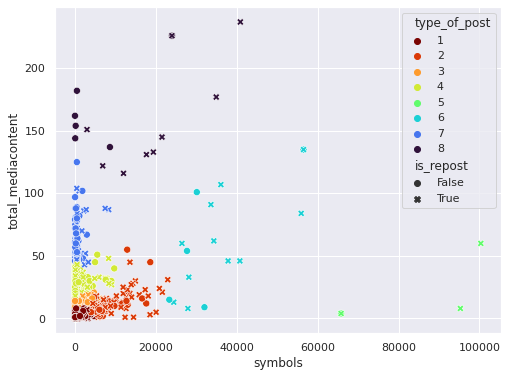

In [31]:
plt.figure(figsize=[8,6])
sns.scatterplot(x=df.symbols, y=df.total_mediacontent, hue=df.type_of_post, 
                style=df.is_repost, palette='turbo_r', s=50, legend='full')

In [32]:
df.replace({'type_of_post': {1: "Заметка", 2: "Лонгрид", 3: "Статья", 4: "Подборка", 5: "Ультра-Лонгрид",
                                  6: "Супер-Лонгрид", 7: "Супер-Подборка", 8: "Ультра-Медиа-Лонгрид"
                                 }}, inplace=True)

In [33]:
df.type_of_post.unique()

array(['Лонгрид', 'Статья', 'Подборка', 'Заметка', 'Ультра-Медиа-Лонгрид',
       'Супер-Подборка', 'Ультра-Лонгрид', 'Супер-Лонгрид'], dtype=object)

<AxesSubplot:xlabel='symbols', ylabel='total_mediacontent'>

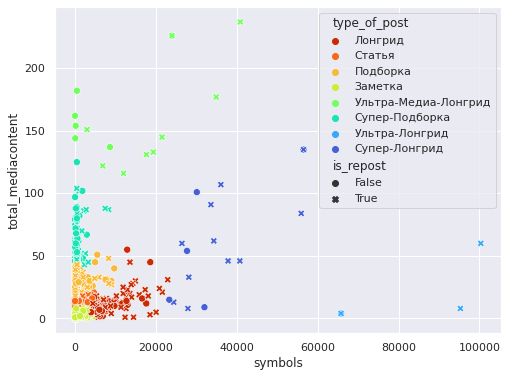

In [34]:
plt.figure(figsize=[8,6])
sns.scatterplot(x=df.symbols, y=df.total_mediacontent, hue=df.type_of_post, 
                style=df.is_repost, palette='turbo_r', s=50, legend='full')

In [35]:
# ДЛЯ ПОСТРОЕНИЯ НОРМАЛЬНОГО ГРАФИКА ВЫБРАН ПОРОГ ПО СИМВОЛАМ: 100. 
# ЗАМЕНИТЬ НА 30 ПОСЛЕ ПОСТРОЕНИЯ ГРАФИКА

df.loc[df[(df.type_of_post == 'Заметка') & (df.total_mediacontent == 1) & 
                    (df.symbols < 30)].index, 'type_of_post'] = 'Мем'
# df.loc[df[(df.type_of_post == "Супер-Лонгрид-1")].index, 'type_of_post'] = "Супер-Лонгрид-2"
# df.replace({'type_of_post': {"Супер-Лонгрид-2": "Супер-Лонгрид"}}, inplace=True)

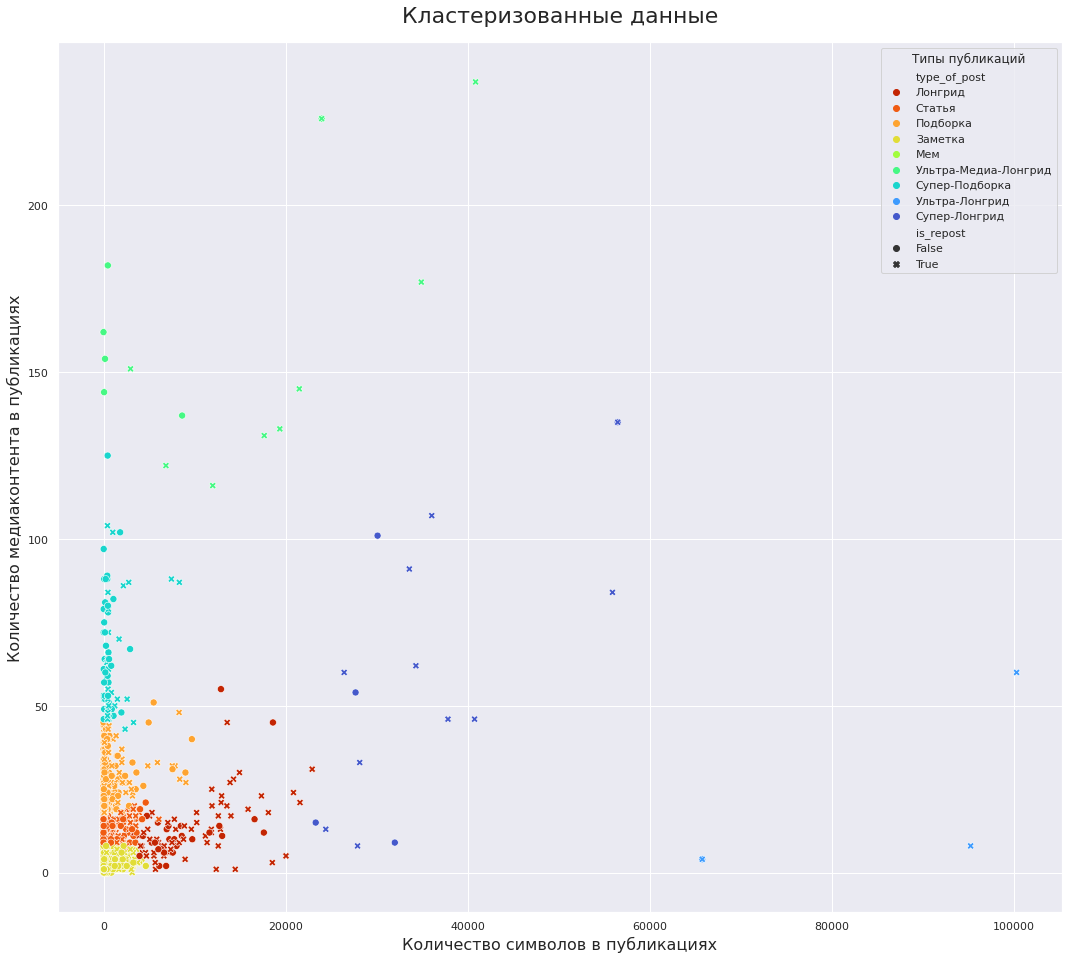

In [36]:
plt.figure(figsize=[18,16])
sns.scatterplot(x=df.symbols, y=df.total_mediacontent, hue=df.type_of_post, 
                style=df.is_repost, palette='turbo_r', s=50, legend='full')

plt.title('Кластеризованные данные', fontsize=22, pad=20)
plt.xlabel('Количество символов в публикациях', fontsize=16)
plt.ylabel('Количество медиаконтента в публикациях', fontsize=16)
plt.legend(title='Типы публикаций', )

# plt.savefig(PATH + "Full_analysis/clustered_labeled_data_final.jpg", dpi=300, bbox_inches='tight')

In [37]:
df[df.type_of_post == 'Мем'].shape

(3364, 31)

In [38]:
len("В этой строке тридцать семь символов!")

37

In [39]:
print(df.type_of_post.value_counts())
print('\n')
print(df.type_of_post.value_counts().index)
print('\n')
print(df.type_of_post.value_counts().values)

Мем                     3364
Заметка                 2944
Статья                   614
Подборка                 369
Лонгрид                   92
Супер-Подборка            74
Супер-Лонгрид             16
Ультра-Медиа-Лонгрид      15
Ультра-Лонгрид             4
Name: type_of_post, dtype: int64


Index(['Мем', 'Заметка', 'Статья', 'Подборка', 'Лонгрид', 'Супер-Подборка',
       'Супер-Лонгрид', 'Ультра-Медиа-Лонгрид', 'Ультра-Лонгрид'],
      dtype='object')


[3364 2944  614  369   92   74   16   15    4]


In [40]:
tmp = df.type_of_post.value_counts()
tmp

Мем                     3364
Заметка                 2944
Статья                   614
Подборка                 369
Лонгрид                   92
Супер-Подборка            74
Супер-Лонгрид             16
Ультра-Медиа-Лонгрид      15
Ультра-Лонгрид             4
Name: type_of_post, dtype: int64

In [41]:
tmp.values.sum()

7492

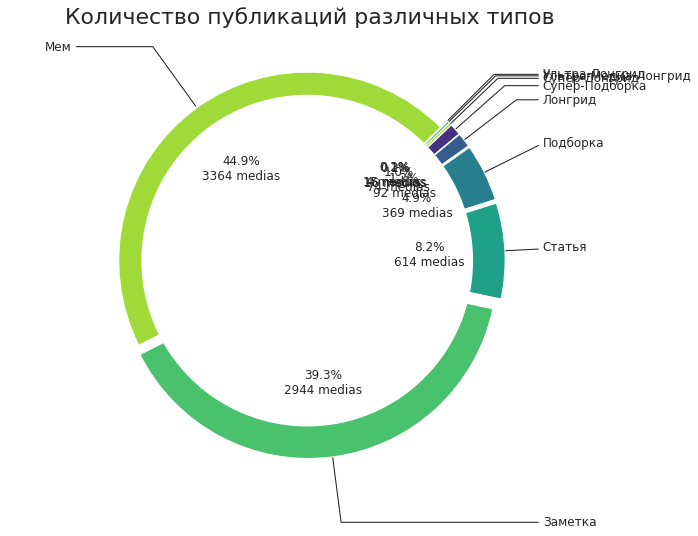

In [42]:
sns.set_palette("viridis_r")

def func(pct, allvals):
    absolute = round(pct/100.*np.sum(allvals))
    return "{:.1f}%\n{:d} medias".format(pct, absolute)

fig=plt.figure(figsize=(14,10))
gs1 = gridspec.GridSpec(1,1,
    left=0.1,right=0.7,
    bottom=0.1,top=0.7,
)
# gs2 = gridspec.GridSpec(1,1,
#     left=0.05,right=0.95,
#     bottom=0.9,top=1.0,
# )

pie_ax=fig.add_subplot(gs1[0])
# title_ax=fig.add_subplot(gs2[0])

# Create a list of colors (from iWantHue)
# colors = ['#66b3ff', '#ffcc99', '#99ff99', '#ff6666']
labels = tmp.index 

# Create a pie chart
wedges = pie_ax.pie(
    tmp.values,
    shadow=False,
#     colors=colors, 
    startangle=45, #frame=True, 
    autopct=lambda pct: func(pct, tmp.values), 
    explode=(0, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05)
)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"), zorder=0, va="center")

for i, p in enumerate(wedges[0]):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle,
#                              "color":colors[i]
                            "color":'k'
                            })
    pie_ax.annotate(labels[i], xy=(x, y), xytext=(1.25*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)


centre_circle = plt.Circle((0,0), 0.88, color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Количество публикаций различных типов', fontsize=22, pad=26)

plt.axis('equal')

# plt.savefig(PATH + "Full_analysis/medias.jpg", dpi=300, bbox_inches='tight')

plt.show()

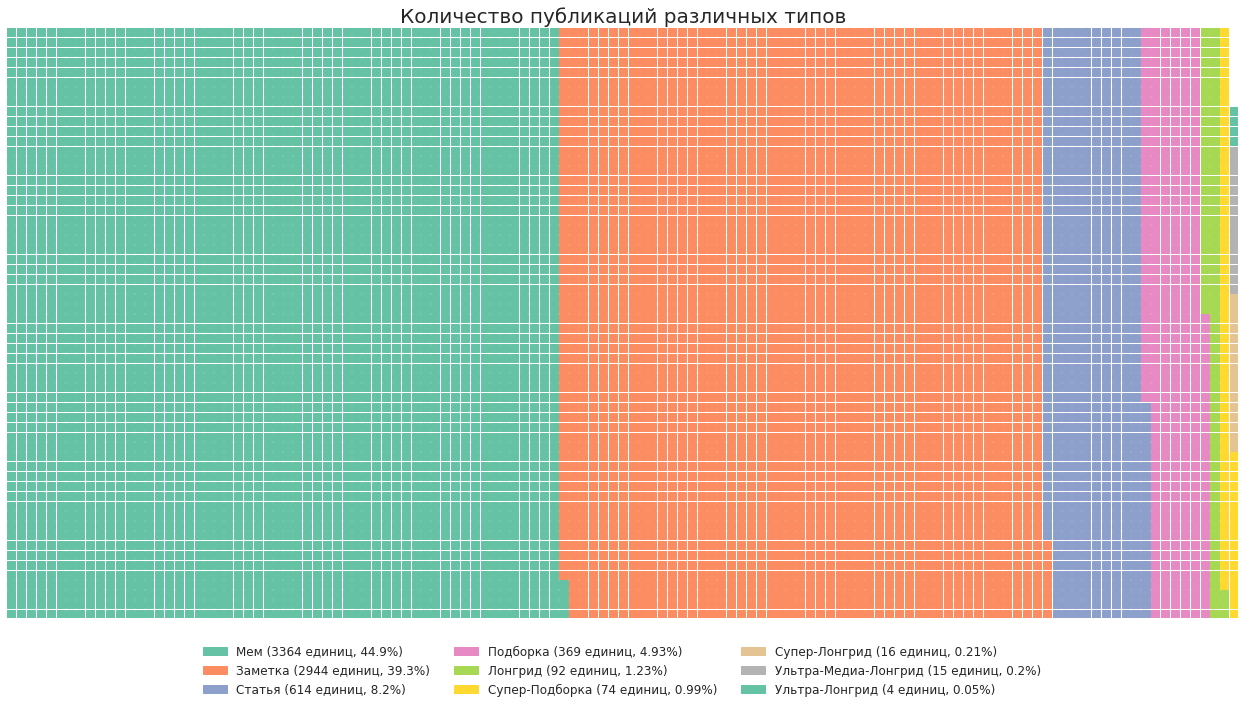

In [43]:
from pywaffle import Waffle

labels = tmp.index
d = {lab: val for lab, val in zip(labels, tmp.values)}

fig = plt.figure(
    FigureClass=Waffle, 
    rows=60, 
    values=list(tmp.values),
#     labels=labels,
    title={
        'label': 'Количество публикаций различных типов',
        'loc': 'center',
        'fontdict': {
            'fontsize': 20
        }
    },
#     labels=[f"{k} ({int(v / sum(d.values()) * 100)}%)" for k, v in d.items()],
    legend={
        'labels': [f"{k} ({v} единиц, {round(v/sum(d.values())*100,2)}%)" for k, v in d.items()],  # labels could also be under legend instead
        'loc': 'lower left',
        'bbox_to_anchor': (0.15, -0.15),
        'ncol': 3,
        'framealpha': 0,
        'fontsize': 12
    },
    figsize=(35, 10),
#     legend={'bbox_to_anchor': (1.3, 0.85)}    
)
# plt.savefig(PATH + "Full_analysis/types_of_posts.jpg", dpi=300, bbox_inches='tight')

In [ ]:
tmp

In [ ]:
(tmp.values[0]) / tmp.values.sum()

In [44]:
df.to_csv(PATH + 'Full_analysis/Clustered_weaboo_data_02_05.csv')

In [45]:
df.to_pickle(PATH + 'Full_analysis/Clustered_weaboo_data_02_05.pkl')

---

In [3]:
df = pd.read_pickle(PATH + 'Full_analysis/Analysed_weaboo_data_02_05.pkl')
df.head()

,date,id,url,author,comments_count,favorites_count,hits_count,is_repost,likes,subsite,...,links,audio,total_mediacontent,hashtags,hour,month,weekday,is_weekend,period,type_of_post
0,2018-03-12 21:59:15,17110,https://dtf.ru/flood/17110-ne-odin-lish-tip-luny,"{'id': 4876, 'url': 'https://dtf.ru/u/4876-geo...",19,32,1999,True,36,Офтоп,...,0,0,45,[#long],21,3,Monday,0,2018-03,Лонгрид
1,2020-01-26 20:38:21,97215,https://dtf.ru/u/92907-aleksey-fedorov/97215-t...,"{'id': 92907, 'url': 'https://dtf.ru/u/92907-a...",11,47,665,True,56,Алексей Фёдоров,...,0,0,17,[#anime],20,1,Sunday,1,2020-01,Статья
2,2020-02-18 19:11:46,104163,https://dtf.ru/u/92907-aleksey-fedorov/104163-...,"{'id': 92907, 'url': 'https://dtf.ru/u/92907-a...",39,23,749,True,49,Алексей Фёдоров,...,0,0,32,"[#anime, #evangelion]",19,2,Tuesday,0,2020-02,Подборка
3,2020-02-29 18:25:10,108055,https://dtf.ru/u/92907-aleksey-fedorov/108055-...,"{'id': 92907, 'url': 'https://dtf.ru/u/92907-a...",7,18,238,True,41,Алексей Фёдоров,...,1,0,20,[#anime],18,2,Saturday,1,2020-02,Подборка
4,2020-03-16 10:36:03,113363,https://dtf.ru/u/4810-oleg-kubaneishvili/11336...,"{'id': 4810, 'url': 'https://dtf.ru/u/4810-ole...",5,8,180,True,15,Олег Кубанеишвили,...,0,0,17,[],10,3,Monday,0,2020-03,Лонгрид


In [4]:
df.shape

(7492, 31)

In [5]:
df.loc[df[(df.type_of_post == 'Заметка') & (df.total_mediacontent == 1) & 
                    (df.symbols < 100)].index, 'type_of_post'] = 'Мем'

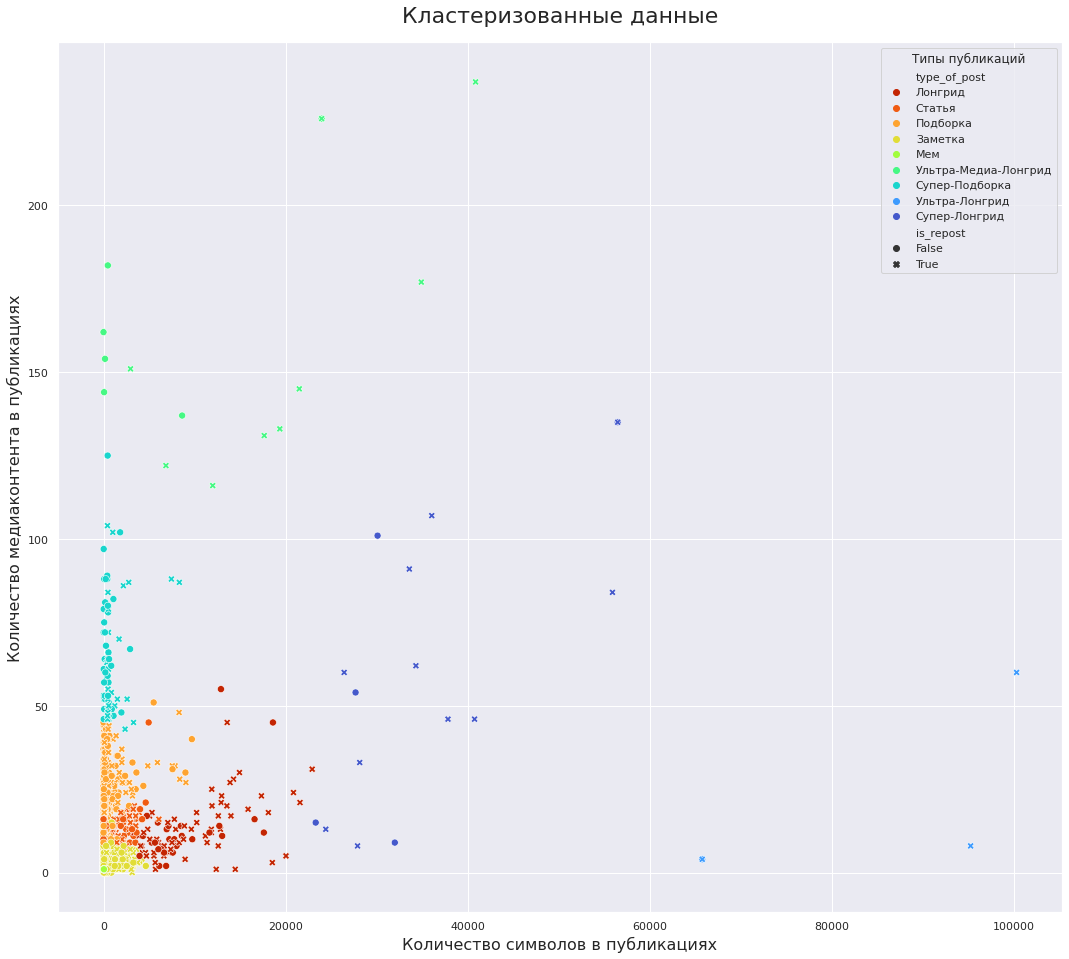

In [7]:
plt.figure(figsize=[18,16])
sns.scatterplot(x=df.symbols, y=df.total_mediacontent, hue=df.type_of_post, 
                style=df.is_repost, palette='turbo_r', s=50, legend='full')

plt.title('Кластеризованные данные', fontsize=22, pad=20)
plt.xlabel('Количество символов в публикациях', fontsize=16)
plt.ylabel('Количество медиаконтента в публикациях', fontsize=16)
plt.legend(title='Типы публикаций', )

# plt.savefig(PATH + "Full_analysis/clustered_labeled_data_final.jpg", dpi=300, bbox_inches='tight')

Альтернативные алгоритмы кластеризации: K-Means, MeanShift

In [ ]:
# from sklearn.cluster import KMeans
# from sklearn import metrics

# inertia = []
# k = range(1, 10)
# for k_i in k:
#     km = KMeans(n_clusters=k_i).fit(X)
#     km.fit(X)
#     inertia.append(km.inertia_)
    
# plt.plot(k, inertia)
# plt.xlabel('k')
# plt.ylabel('inertia')
# plt.title('The Elbow Method showing the optimal k')

In [ ]:
# from sklearn.metrics import silhouette_score
# inertia = []
# k = range(2, 10)
# for k_i in k:
#     km = KMeans(n_clusters=k_i).fit(X)
#     km.fit(X)
#     inertia.append(silhouette_score(X, km.labels_))

# print(inertia)
    
# plt.plot(k, inertia)
# plt.xlabel('k')
# plt.ylabel('silhouette_score')
# plt.title('The Elbow Method showing the optimal k')

In [ ]:
# kmeans = KMeans(n_clusters=4, random_state=10)
# y_pred = kmeans.fit_predict(X)

# # Plot the prediction
# # plt.scatter(X[:,0], X[:,1], c=y_pred)
# sns.scatterplot(x=X[:,0], y=X[:,1], hue=y_pred)
# # plt.savefig(PATH + "Full_analysis/fail_KMeans.jpg", dpi=300, bbox_inches='tight')

In [ ]:
# from sklearn.cluster import SpectralClustering

# X = np.array([df.symbols, df.total_mediacontent]).T
# X

Очень долго работало и не доработало до конца. Нужно попробовать в колабе.

In [ ]:
# clustering = SpectralClustering(n_clusters=5, assign_labels="discretize", affinity='rbf')
# y_pred = clustering.fit_predict(X)

# plt.rcParams["figure.figsize"] = [20, 16]
# print(np.unique(y_pred))

# sns.scatterplot(x=X[:,0], y=X[:,1], hue=y_pred, palette='turbo')

In [ ]:
# from sklearn import cluster
# from sklearn.cluster import MeanShift

# bandwidth = cluster.estimate_bandwidth(X, quantile=0.2, n_samples=50)
# ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
# y_pred = ms.fit_predict(X)

# plt.rcParams["figure.figsize"] = [20, 16]
# print(np.unique(y_pred))

# labels = ms.labels_
# cluster_centers = ms.cluster_centers_

# labels_unique = np.unique(labels)
# n_clusters_ = len(labels_unique)

# print("number of estimated clusters : %d" % n_clusters_)

# sns.scatterplot(x=X[:,0], y=X[:,1], hue=y_pred, palette='turbo')
# plt.savefig(PATH + "Full_analysis/fail_EM.jpg", dpi=300, bbox_inches='tight')

# # from itertools import cycle
# # colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
# # for k, col in zip(range(n_clusters_), colors):
# #     my_members = labels == k
# #     cluster_center = cluster_centers[k]
# #     plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
# #     plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
# #              markeredgecolor='k', markersize=14)
# # plt.title('Estimated number of clusters: %d' % n_clusters_)
# # plt.show()

Почему нормально не сошлись алгоритмы кластеризации? 
#### Потому что я сделал чушь. Основные метрики использованных алгоритмов - плотность и расстояние. Учитывая, что я не нормализировал и не стандартизировал входные данные - алгоритмы просто не могли нормально сойтись. 

Слишком высокая дисперсия по абсциссе, по отношению к дисперсию по ординате. 
#### НОРМАЛИЗАЦИЯ НУЖНА ОБЯЗАТЕЛЬНО!

Для DBSCAN важны параметры эпсилон и н_сэмплс - т. е. эпсилон-окрестность точки и количество точек, входящих в эту окрестность, которые необходимы для определения их принадлежности к одному кластеру. 